# Assignment 2: Predicting Fast Growth of Firms
## Part 1 – Probability Prediction, Classification & Evaluation

**Input:** `bisnode_firms_clean_growth.csv` (from `01_data_prep_fast_growth.ipynb`)  
**Models:** Logit (simple), Logit + LASSO, Random Forest  
**Structure:** Follows the ch17 firm-exit prediction pipeline.

---

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

## 0. Set Up Paths & Load Data

In [2]:
base_dir = os.path.join(os.getcwd(), "..")  # assumes notebook runs from code/

data_clean = os.path.join(base_dir, "data", "clean")
output_dir = os.path.join(base_dir, "output")

os.makedirs(output_dir, exist_ok=True)

In [3]:
data = pd.read_csv(os.path.join(data_clean, "bisnode_firms_clean_growth.csv"))
print(f"Dataset shape: {data.shape}")
print(f"\nTarget distribution:")
print(data["fast_growth"].value_counts())
print(f"\nShare of fast-growth firms: {data['fast_growth'].mean()*100:.1f}%")

Dataset shape: (19036, 123)

Target distribution:
fast_growth
0    15393
1     3643
Name: count, dtype: int64

Share of fast-growth firms: 19.1%


## 1. Helper Functions

In [4]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    """Generate predictions for a specific fold from LogisticRegressionCV."""
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss, FP, FN):
    """Plot expected loss as a function of classification threshold."""
    ac = all_coords.copy()
    ac["loss"] = (ac.false_pos * FP + ac.false_neg * FN) / ac.n

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ac["thresholds"], ac["loss"])
    ax.axvline(x=optimal_threshold, linestyle="--", color="red", alpha=0.7)
    ax.text(
        optimal_threshold + 0.02, curr_exp_loss,
        f"Best threshold: {optimal_threshold:.3f}\nExp. loss: {curr_exp_loss:.3f}",
        fontsize=9,
    )
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Expected loss per observation")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    return fig


def create_roc_plot(y_true, y_pred, title="ROC Curve"):
    """Plot ROC curve with AUC shading."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_val = roc_auc_score(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, linewidth=1.2, label=f"AUC = {auc_val:.3f}")
    ax.fill_between(fpr, tpr, alpha=0.2, color="mediumaquamarine")
    ax.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.8)
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    return fig


def create_roc_plot_with_optimal(all_coords, optimal_threshold, title="ROC with Optimal Threshold"):
    """ROC curve with the optimal threshold point highlighted."""
    ac = all_coords.copy()
    ac["sp"] = 1 - ac.true_neg / ac.neg  # false positive rate
    ac["se"] = ac.true_pos / ac.pos       # true positive rate (sensitivity)

    best = ac[ac.thresholds == optimal_threshold]
    sp_val = best.sp.values[0]
    se_val = best.se.values[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(ac["sp"], ac["se"], linewidth=1.2)
    ax.fill_between(ac["sp"], ac["se"], alpha=0.2, color="mediumaquamarine")
    ax.scatter(sp_val, se_val, color="red", s=60, zorder=5)
    ax.text(sp_val + 0.02, se_val - 0.04,
            f"({sp_val:.2f}, {se_val:.2f})", fontsize=9)
    ax.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.8)
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity)")
    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    return fig

## 2. Define Variable Sets

We build model specifications of increasing complexity, just like the exit-prediction pipeline.

In [5]:
# Variable groups (same as data prep) 
rawvars = [
    "curr_assets", "curr_liab", "extra_exp", "extra_inc",
    "extra_profit_loss", "fixed_assets", "inc_bef_tax", "intang_assets",
    "inventories", "liq_assets", "material_exp", "personnel_exp",
    "profit_loss_year", "sales", "share_eq", "subscribed_cap",
]

qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

engvar = [
    "total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
    "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs",
    "extra_exp_pl", "extra_inc_pl", "extra_profit_loss_pl",
    "inc_bef_tax_pl", "inventories_pl", "material_exp_pl",
    "profit_loss_year_pl", "personnel_exp_pl",
]

engvar2 = [
    "extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad", "share_eq_bs_quad",
]

# Auto-detect flag variables from the data
engvar3 = [
    col for col in data.columns
    if col.endswith("flag_low") or col.endswith("flag_high")
    or col.endswith("flag_error") or col.endswith("flag_zero")
]

d1 = [
    "d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log",
]

hr = [
    "female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
    "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
    "flag_miss_labor_avg", "foreign_management",
]

firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions1 = [
    "C(ind2_cat)*age", "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod", "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age", "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female", "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age", "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

### Model specifications

We define three logit models of increasing complexity, a LASSO, and a random forest:

| Model | Description |
|---|---|
| **M1** | Baseline: log sales + sales growth + profitability + industry |
| **M2** | M1 + balance-sheet ratios + age + foreign management |
| **M3** | Full: all financial ratios + growth + HR + firm demographics + interactions |
| **LASSO** | Same variable set as M3, with L1 regularisation (automatic variable selection) |
| **RF** | Random forest on raw + engineered variables (no formula interactions needed) |

In [6]:
# Logit model specifications
M1 = [
    "sales_mil_log", "sales_mil_log_sq",
    "d1_sales_mil_log_mod", "profit_loss_year_pl",
    "C(ind2_cat)",
]

M2 = [
    "sales_mil_log", "sales_mil_log_sq",
    "d1_sales_mil_log_mod", "profit_loss_year_pl",
    "fixed_assets_bs", "share_eq_bs",
    "curr_liab_bs", "curr_liab_bs_flag_high",
    "age", "foreign_management",
    "C(ind2_cat)",
]

M3 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm + engvar + engvar2 + engvar3 + d1 + hr + qualityvars
    + interactions1 + interactions2
)

# LASSO uses the same rich set as M3
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar + engvar2 + engvar3 + d1 + hr + firm + qualityvars
    + interactions1 + interactions2
)

# Random forest variables (no patsy interactions)
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

print("Model variable counts:")
for name, vlist in [("M1", M1), ("M2", M2), ("M3", M3), ("LASSO", logit_lasso_vars), ("RF", rfvars)]:
    print(f"  {name}: {len(vlist)} formula terms")

Model variable counts:
  M1: 5 formula terms
  M2: 11 formula terms
  M3: 84 formula terms
  LASSO: 84 formula terms
  RF: 36 formula terms


## 3. Train–Holdout Split

In [7]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

print(f"Train: {len(data_train)}  |  Holdout: {len(data_holdout)}")
print(f"\nTarget rates:")
print(f"  Total:   {data['fast_growth'].mean()*100:.1f}%")
print(f"  Train:   {data_train['fast_growth'].mean()*100:.1f}%")
print(f"  Holdout: {data_holdout['fast_growth'].mean()*100:.1f}%")

Train: 15228  |  Holdout: 3808

Target rates:
  Total:   19.1%
  Train:   19.1%
  Holdout: 19.4%


---

# PART I: Probability Prediction

We estimate predicted probabilities of fast growth using 5-fold cross-validation,
and compare models using **CV RMSE** (root mean Brier score) and **CV AUC**.

In [8]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### 3a. Cross-validated logit models

In [9]:
C_value_logit = [1e20]  # no regularisation

logit_model_vars = [M1, M2, M3]
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):
    model_name = f"M{i+1}"
    model_equation = "fast_growth ~ " + " + ".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
        max_iter=500,
    )

    logit_models[model_name] = LRCV.fit(X_train, y_train)

    # CV RMSE (from Brier score)
    CV_RMSE_folds[model_name] = np.sqrt(
        -1 * logit_models[model_name].scores_[1].ravel()
    )

    print(f"{model_name}: mean CV RMSE = {CV_RMSE_folds[model_name].mean():.4f}"
          f"  (n_features = {X_train.shape[1]})")

M1: mean CV RMSE = 0.3878  (n_features = 12)
M2: mean CV RMSE = 0.3826  (n_features = 18)
M3: mean CV RMSE = 0.3800  (n_features = 154)


### 3b. Logit + LASSO

In [10]:
# Build design matrix for LASSO
model_equation = "fast_growth ~ " + " + ".join(logit_lasso_vars)
y_train_lasso, X_train_lasso = patsy.dmatrices(model_equation, data_train)

# Normalise X for LASSO
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train_lasso),
    columns=X_train_lasso.design_info.column_names,
)

print(f"LASSO design matrix: {normalized_logitvars.shape}")

LASSO design matrix: (15228, 154)


In [11]:
# Set regularisation grid
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]

# Fit LASSO
logLasso = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train_lasso)

# CV summary across lambdas
lasso_cv = pd.DataFrame({
    "lambdas": lambdas,
    "C_values": C_values,
    "mean_cv_rmse": np.sqrt(-1 * logit_models["LASSO"].scores_[1].mean(axis=0)),
})
best_lambda_i = lasso_cv["mean_cv_rmse"].idxmin()

CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

n_nonzero = sum(x != 0 for x in logit_models["LASSO"].coef_[0])
print(f"LASSO: mean CV RMSE = {CV_RMSE_folds['LASSO'].mean():.4f}")
print(f"  Best lambda index: {best_lambda_i}")
print(f"  Non-zero coefficients: {n_nonzero} / {len(logit_models['LASSO'].coef_[0])}")

LASSO: mean CV RMSE = 0.3790
  Best lambda index: 6
  Non-zero coefficients: 107 / 154


### 3c. CV AUC for logit models and LASSO

We re-fit with AUC scoring to get fold-level AUC values.

In [12]:
CV_AUC_folds = dict()

for i, model_vars in enumerate(logit_model_vars):
    model_name = f"M{i+1}"
    model_equation = "fast_growth ~ " + " + ".join(model_vars)
    y_train_i, X_train_i = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
        max_iter=500,
    )
    logit_models[model_name] = LRCV_auc.fit(X_train_i, y_train_i)
    CV_AUC_folds[model_name] = logit_models[model_name].scores_[1].ravel()

# LASSO AUC
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train_lasso)
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][:, best_lambda_i]

### 3d. Random Forest

In [13]:
# Build RF design matrix
y_train_rf, rfvars_train = patsy.dmatrices(
    "fast_growth ~ " + " + ".join(rfvars), data_train
)
y_holdout_rf, rfvars_holdout = patsy.dmatrices(
    "fast_growth ~ " + " + ".join(rfvars), data_holdout
)

print(f"RF design matrix: {rfvars_train.shape}")

RF design matrix: (15228, 45)


In [14]:
# Hyperparameter grid
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
}

prob_forest = RandomForestClassifier(
    random_state=42, n_estimators=500, oob_score=True
)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train_rf)
print(f"Best RF params: {prob_forest_fit.best_params_}")

Best RF params: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}


In [15]:
# RF CV results
prob_forest_cv_results = pd.DataFrame({
    "max_features": prob_forest_fit.cv_results_["param_max_features"],
    "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
    "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
    "cv_rmse": np.sqrt(
        prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
    ),
})

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.684275,0.376143
1,5,16,0.685489,0.375862
2,6,11,0.683183,0.376152
3,6,16,0.683018,0.376114
4,7,11,0.681932,0.376450
5,7,16,0.682624,0.376344


In [16]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]

# Extract fold-level RMSE and AUC for RF
best_idx = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
].index.values[0]

CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

### 3e. PART I Summary – CV Performance

In [17]:
summary = pd.DataFrame({
    "CV RMSE": {k: v.mean() for k, v in CV_RMSE_folds.items()},
    "CV AUC": {k: v.mean() for k, v in CV_AUC_folds.items()},
})
summary.index.name = "Model"
summary = summary.round(4)
summary

,CV RMSE,CV AUC
Model,,
M1,0.3878,0.6080
M2,0.3826,0.6500
M3,0.3800,0.6695
LASSO,0.3790,0.6724
RF,0.3759,0.6855


In [18]:
# Fold-level detail: RMSE
print("CV RMSE by fold:")
print(pd.DataFrame(CV_RMSE_folds).round(4))
print()
print("CV AUC by fold:")
print(pd.DataFrame(CV_AUC_folds).round(4))

CV RMSE by fold:
       M1      M2      M3   LASSO      RF
0  0.3857  0.3805  0.3785  0.3777  0.3726
1  0.3927  0.3876  0.3841  0.3830  0.3792
2  0.3874  0.3819  0.3807  0.3787  0.3772
3  0.3829  0.3795  0.3764  0.3757  0.3743
4  0.3900  0.3838  0.3802  0.3797  0.3759

CV AUC by fold:
       M1      M2      M3   LASSO      RF
0  0.6015  0.6528  0.6722  0.6709  0.6951
1  0.6045  0.6463  0.6761  0.6804  0.6886
2  0.6185  0.6617  0.6671  0.6760  0.6776
3  0.6037  0.6327  0.6598  0.6592  0.6680
4  0.6119  0.6563  0.6725  0.6756  0.6981


### PART I – Evaluation

Based on the CV tables, Random Forest (RF) is the clear top performer overall. It achieves the lowest CV RMSE across all folds (around 0.373–0.379), meaning it produces the most accurate probability predictions in terms of calibration/error. RF also delivers the highest CV AUC values (roughly 0.67–0.70), indicating the strongest ability to discriminate between fast-growing and non–fast-growing firms. 

Among the logistic models, performance improves gradually from M1 → M3, with M3 being the best of the standard logit specifications. LASSO is only marginally different from M3: it slightly improves RMSE and is competitive on AUC, but the gains are small, suggesting that shrinkage helps a bit but does not dramatically outperform the richer logit model. 

**Overall, RF appears to dominate because it can capture nonlinearities and interactions that linear logit models miss.**

In terms of the bias–variance trade-off, the simpler logit models (M1/M2) have higher bias but low variance, while LASSO reduces variance through regularization. RF sits at the more flexible, lower-bias end of the spectrum, and its strong CV performance suggests the added complexity is paying off without excessive overfitting. 

**Model choice for holdout evaluation:** Therefore, RF is the best candidate to carry forward for holdout evaluation.

In [19]:
# Holdout RMSE for the best logit/lasso
best_logit_name = "LASSO"  

model_equation = "fast_growth ~ " + " + ".join(logit_model_vars[
    ["M1", "M2", "M3"].index(best_logit_name)
] if best_logit_name != "LASSO" else logit_lasso_vars)
_, X_holdout_logit = patsy.dmatrices(model_equation, data_holdout)

if best_logit_name == "LASSO":
    X_holdout_logit = pd.DataFrame(
        StandardScaler().fit_transform(X_holdout_logit),
        columns=X_holdout_logit.design_info.column_names,
    )

data_holdout = data_holdout.copy()
data_holdout["best_logit_pred"] = logit_models[best_logit_name].predict_proba(
    X_holdout_logit
)[:, 1]

logit_holdout_rmse = rmse(data_holdout["best_logit_pred"], data_holdout["fast_growth"])
logit_holdout_auc = roc_auc_score(data_holdout["fast_growth"], data_holdout["best_logit_pred"])

print(f"Best logit ({best_logit_name}) – Holdout RMSE: {logit_holdout_rmse:.4f}")
print(f"Best logit ({best_logit_name}) – Holdout AUC:  {logit_holdout_auc:.4f}")

Best logit (LASSO) – Holdout RMSE: 0.3821
Best logit (LASSO) – Holdout AUC:  0.6666


In [20]:
# Holdout RMSE & AUC for RF
rf_pred_holdout = prob_forest_fit.best_estimator_.predict_proba(rfvars_holdout)[:, 1]
rf_holdout_rmse = np.sqrt(mean_squared_error(y_holdout_rf, rf_pred_holdout))
rf_holdout_auc = roc_auc_score(y_holdout_rf, rf_pred_holdout)

print(f"RF – Holdout RMSE: {rf_holdout_rmse:.4f}")
print(f"RF – Holdout AUC:  {rf_holdout_auc:.4f}")

RF – Holdout RMSE: 0.3805
RF – Holdout AUC:  0.6757


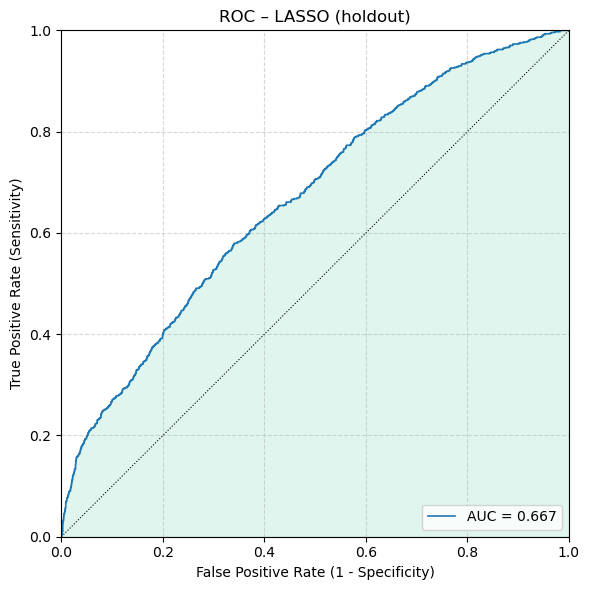

In [22]:
# ROC curve on holdout – best logit
fig = create_roc_plot(
    data_holdout["fast_growth"], data_holdout["best_logit_pred"],
    title=f"ROC – {best_logit_name} (holdout)"
)
fig.savefig(os.path.join(output_dir, "roc_best_logit_holdout.png"),
            dpi=150, bbox_inches="tight")
plt.show()

---

# PART II: Classification

## 4. Loss Function Definition

### Business context

We frame the prediction problem as an **investor / lender screening tool**: a financial
institution wants to identify firms with high growth potential, either to target them
for equity investment, credit expansion, or partnership opportunities.

**Two types of classification errors and their costs:**

| Error | Description | Cost |
|---|---|---|
| **False Positive (FP)** | Predict fast growth, but firm does *not* grow fast. The institution invests resources in due diligence, meetings, or extends favourable terms to a firm that turns out to be a mediocre performer. | Moderate: wasted screening costs + potential opportunity cost of capital, but limited downside (the firm likely survives, just doesn't grow). |
| **False Negative (FN)** | Predict no fast growth, but firm *does* grow fast. The institution misses a high-potential firm — a competitor captures the deal, or the firm grows without our participation. | Higher: lost upside from a winning investment. In venture/growth finance, the best deals generate outsized returns that subsidise the portfolio. Missing winners is the cardinal sin of growth investing. |

### Our loss function

We set **FP = 1** and **FN = 2**, meaning that missing a fast-growing firm is twice as
costly as wasting resources on a non-grower. This is a conservative asymmetry — in practice,
growth-equity investors often face much higher FN/FP ratios (e.g. 5:1 or 10:1), but
we keep it moderate because:

1. Our "fast growth" is top-quartile, not unicorn-level, so the upside of any single winner
   is bounded.
2. FP costs are not negligible for a bank (misallocated credit lines carry risk).
3. A 2:1 ratio is enough to meaningfully shift the optimal threshold below 0.5 and
   illustrate the classification trade-off.

$$\text{Expected Loss} = \frac{FP \times 1 + FN \times 2}{N}$$

In [23]:
FP = 1
FN = 2
cost = FN / FP
print(f"Loss function: FP = {FP}, FN = {FN}, cost ratio = {cost}")

Loss function: FP = 1, FN = 2, cost ratio = 2.0


## 5. Optimal Threshold Search (CV)

For each model and each CV fold:
1. Predict probabilities on the fold's test set.
2. Sweep thresholds using the ROC curve.
3. Find the threshold that minimises expected loss.
4. Average across folds.

In [24]:
prevelance = data_train["fast_growth"].sum() / len(data_train)
print(f"Prevalence (share of fast_growth in train): {prevelance:.4f}")

Prevalence (share of fast_growth in train): 0.1906


In [25]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

# Logit models
for i, model_name in enumerate(["M1", "M2", "M3"]):
    best_thresholds = []
    expected_loss = []

    _, X = patsy.dmatrices(
        "fast_growth ~ " + " + ".join(logit_model_vars[i]), data_train
    )
    X = pd.DataFrame(X)
    c_index = 0

    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        fpr, tpr, thresholds = roc_curve(y_fold, pred_fold)

        # Optimal threshold: maximise weighted distance from diagonal
        optimal_threshold = sorted(
            list(zip(
                np.abs(tpr + (1 - prevelance) / (cost * prevelance) * (1 - fpr)),
                thresholds,
            )),
            key=lambda x: x[0], reverse=True,
        )[0][1]

        best_thresholds.append(optimal_threshold)
        threshold_pred = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp_, fn_, tp = confusion_matrix(
            y_fold, threshold_pred, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp_ * FP + fn_ * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold += 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # Save fold 5 for plotting
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss
    fold5_all_coords[model_name] = pd.DataFrame({
        "false_pos": fpr * sum(y_fold == 0),
        "true_pos": tpr * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - tpr * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - fpr * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": thresholds,
    })

    print(f"{model_name}: avg threshold = {best_thresholds_cv[model_name]:.3f}, "
          f"avg exp loss = {expected_loss_cv[model_name]:.4f}")

M1: avg threshold = 0.333, avg exp loss = 0.3717
M2: avg threshold = 0.351, avg exp loss = 0.3597
M3: avg threshold = 0.345, avg exp loss = 0.3469


In [26]:
# LASSO
best_thresholds = []
expected_loss = []

fold = 0
for train_index, test_index in k.split(normalized_logitvars):
    X_fold = normalized_logitvars.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]
    pred_fold = generate_fold_prediction(
        logit_models["LASSO"], X_fold, fold, best_lambda_i
    )
    fpr, tpr, thresholds = roc_curve(y_fold, pred_fold)

    optimal_threshold = sorted(
        list(zip(
            np.abs(tpr + (1 - prevelance) / (cost * prevelance) * (1 - fpr)),
            thresholds,
        )),
        key=lambda x: x[0], reverse=True,
    )[0][1]

    best_thresholds.append(optimal_threshold)
    threshold_pred = np.where(pred_fold < optimal_threshold, 0, 1)
    tn, fp_, fn_, tp = confusion_matrix(
        y_fold, threshold_pred, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp_ * FP + fn_ * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

best_thresholds_cv["LASSO"] = np.mean(best_thresholds)
expected_loss_cv["LASSO"] = np.mean(expected_loss)
fold5_threshold["LASSO"] = optimal_threshold
fold5_expected_loss["LASSO"] = curr_exp_loss
fold5_all_coords["LASSO"] = pd.DataFrame({
    "false_pos": fpr * sum(y_fold == 0),
    "true_pos": tpr * sum(y_fold == 1),
    "false_neg": sum(y_fold == 1) - tpr * sum(y_fold == 1),
    "true_neg": sum(y_fold == 0) - fpr * sum(y_fold == 0),
    "pos": sum(y_fold == 1),
    "neg": sum(y_fold == 0),
    "n": len(y_fold),
    "thresholds": thresholds,
})

print(f"LASSO: avg threshold = {best_thresholds_cv['LASSO']:.3f}, "
      f"avg exp loss = {expected_loss_cv['LASSO']:.4f}")

LASSO: avg threshold = 0.357, avg exp loss = 0.3443


In [27]:
# Random Forest
best_thresholds = []
expected_loss = []
rfvars_train_df = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train_df):
    X_fold = rfvars_train_df.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train_df.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    rf_fold = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    rf_fold.fit(X_fold_train, y_fold_train)
    pred_fold = rf_fold.predict_proba(X_fold)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_fold, pred_fold)

    optimal_threshold = sorted(
        list(zip(
            np.abs(tpr + (1 - prevelance) / (cost * prevelance) * (1 - fpr)),
            thresholds,
        )),
        key=lambda x: x[0], reverse=True,
    )[0][1]

    best_thresholds.append(optimal_threshold)
    threshold_pred = np.where(pred_fold < optimal_threshold, 0, 1)
    tn, fp_, fn_, tp = confusion_matrix(
        y_fold, threshold_pred, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp_ * FP + fn_ * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

best_thresholds_cv["RF"] = np.mean(best_thresholds)
expected_loss_cv["RF"] = np.mean(expected_loss)
fold5_threshold["RF"] = optimal_threshold
fold5_expected_loss["RF"] = curr_exp_loss
fold5_all_coords["RF"] = pd.DataFrame({
    "false_pos": fpr * sum(y_fold == 0),
    "true_pos": tpr * sum(y_fold == 1),
    "false_neg": sum(y_fold == 1) - tpr * sum(y_fold == 1),
    "true_neg": sum(y_fold == 0) - fpr * sum(y_fold == 0),
    "pos": sum(y_fold == 1),
    "neg": sum(y_fold == 0),
    "n": len(y_fold),
    "thresholds": thresholds,
})

print(f"RF: avg threshold = {best_thresholds_cv['RF']:.3f}, "
      f"avg exp loss = {expected_loss_cv['RF']:.4f}")

RF: avg threshold = 0.360, avg exp loss = 0.3410


### Classification Summary – All Models

In [28]:
classification_summary = pd.DataFrame({
    "CV RMSE": {k: v.mean() for k, v in CV_RMSE_folds.items()},
    "CV AUC": {k: v.mean() for k, v in CV_AUC_folds.items()},
    "Avg optimal threshold": best_thresholds_cv,
    "Avg expected loss": expected_loss_cv,
})
classification_summary.index.name = "Model"
classification_summary = classification_summary.round(4)
classification_summary

,CV RMSE,CV AUC,Avg optimal threshold,Avg expected loss
Model,,,,
M1,0.3878,0.6080,0.3329,0.3717
M2,0.3826,0.6500,0.3505,0.3597
M3,0.3800,0.6695,0.3449,0.3469
LASSO,0.3790,0.6724,0.3569,0.3443
RF,0.3759,0.6855,0.3596,0.3410


### PART II – Evaluation

Across models, the Random Forest achieves the lowest average expected loss (0.3410), making it the best performer under the specified misclassification costs. LASSO and M3 follow closely, but RF still provides the most cost-efficient predictions overall. 

The optimal decision thresholds are fairly similar across models, ranging from about 0.33 to 0.36, with RF using an average threshold of 0.3596. All thresholds are well below 0.5, which is expected in a cost-sensitive setting: because false positives are more expensive than false negatives (FP > FN), the classifier becomes more conservative and requires a higher predicted probability before labeling a firm as fast-growing. 

**Compared to the logistic models, RF not only improves RMSE and AUC but also delivers the lowest loss, suggesting that its ability to capture nonlinear patterns translates into better decisions when prediction errors carry asymmetric costs.**

### Loss and ROC plots (Fold 5)

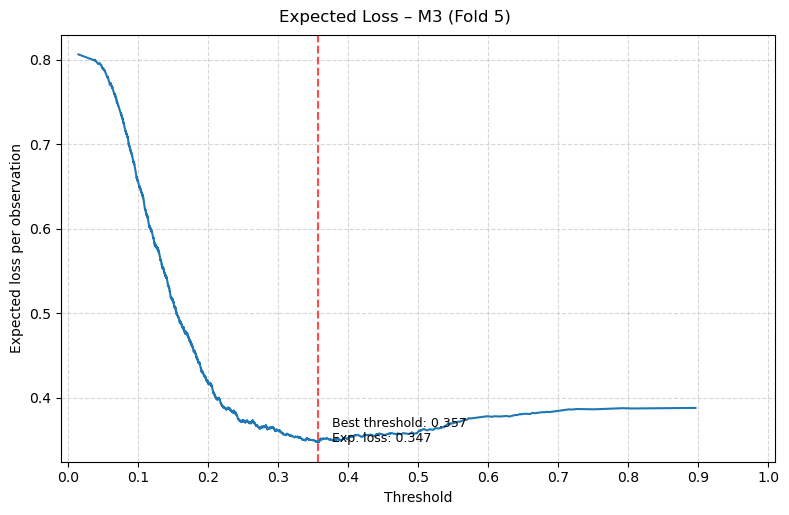

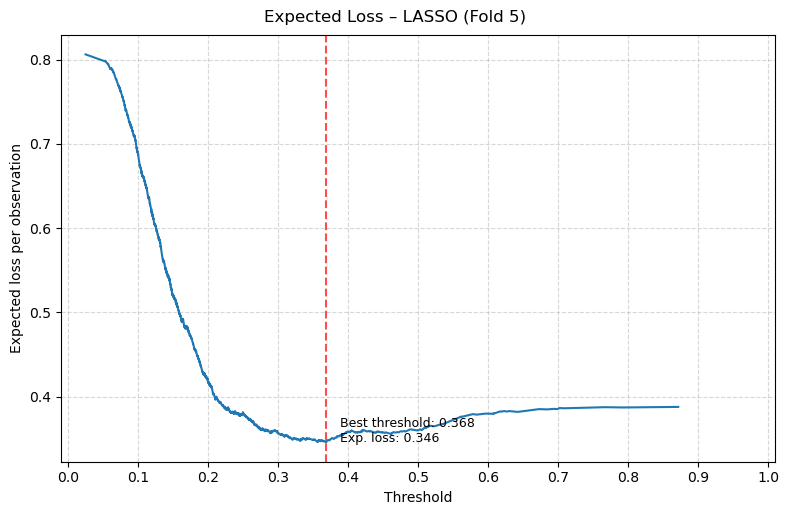

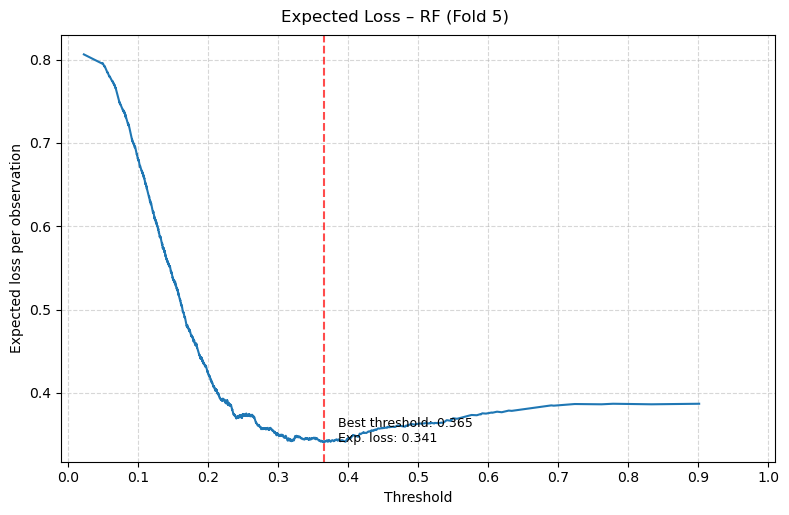

In [29]:
# Loss plots for selected models
for model_name in [ "M3", "LASSO", "RF"]:
    fig = create_loss_plot(
        fold5_all_coords[model_name],
        fold5_threshold[model_name],
        fold5_expected_loss[model_name],
        FP, FN,
    )
    fig.suptitle(f"Expected Loss – {model_name} (Fold 5)", fontsize=12, y=1.02)
    fig.savefig(
        os.path.join(output_dir, f"loss_plot_{model_name}.png"),
        dpi=150, bbox_inches="tight",
    )
    plt.show()

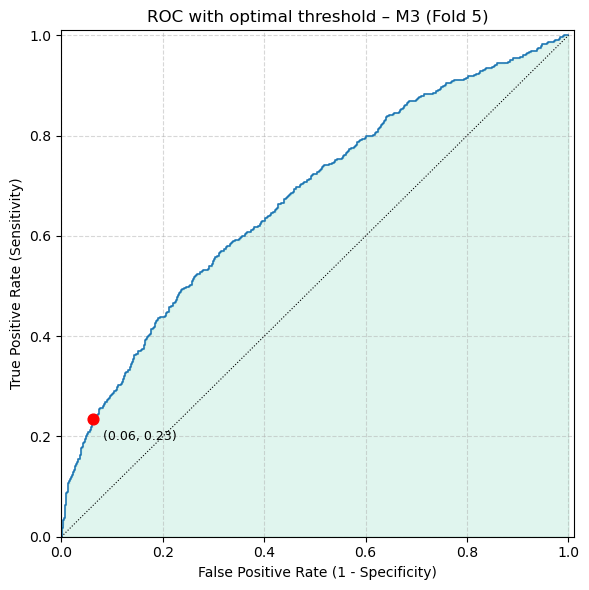

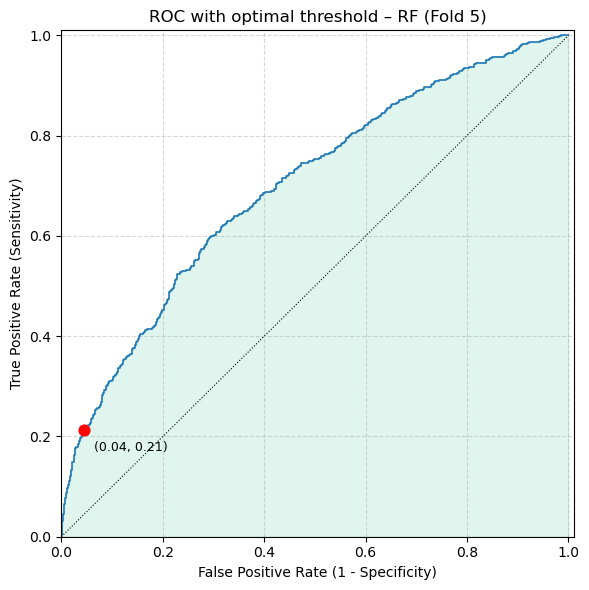

In [30]:
# ROC with optimal threshold for selected models
for model_name in ["M3", "RF"]:
    fig = create_roc_plot_with_optimal(
        fold5_all_coords[model_name],
        fold5_threshold[model_name],
        title=f"ROC with optimal threshold – {model_name} (Fold 5)",
    )
    fig.savefig(
        os.path.join(output_dir, f"roc_optimal_{model_name}.png"),
        dpi=150, bbox_inches="tight",
    )
    plt.show()

## 6. Holdout Evaluation with Best Model

Random Forest is the best model based on CV expected loss and evaluate on holdout.


In [31]:
# Best model
best_model_name = "RF"  

best_threshold = best_thresholds_cv[best_model_name]
print(f"Best model: {best_model_name}")
print(f"Optimal threshold (CV avg): {best_threshold:.4f}")

Best model: RF
Optimal threshold (CV avg): 0.3596


In [32]:
# Get holdout predictions for the best model
if best_model_name == "RF":
    holdout_pred_proba = prob_forest_fit.best_estimator_.predict_proba(
        rfvars_holdout
    )[:, 1]
    y_holdout_eval = y_holdout_rf.ravel()
elif best_model_name == "LASSO":
    holdout_pred_proba = logit_models["LASSO"].predict_proba(
        pd.DataFrame(
            StandardScaler().fit_transform(X_holdout_logit),
            columns=X_holdout_logit.design_info.column_names
            if hasattr(X_holdout_logit, "design_info")
            else None,
        )
    )[:, 1]
    y_holdout_eval = data_holdout["fast_growth"].values
else:
    model_eq = "fast_growth ~ " + " + ".join(
        logit_model_vars[["M1", "M2", "M3"].index(best_model_name)]
    )
    _, X_holdout_best = patsy.dmatrices(model_eq, data_holdout)
    holdout_pred_proba = logit_models[best_model_name].predict_proba(
        X_holdout_best
    )[:, 1]
    y_holdout_eval = data_holdout["fast_growth"].values

In [33]:
# Holdout expected loss
holdout_class = np.where(holdout_pred_proba < best_threshold, 0, 1)
tn, fp_h, fn_h, tp_h = confusion_matrix(
    y_holdout_eval, holdout_class, labels=[0, 1]
).ravel()

holdout_exp_loss = (fp_h * FP + fn_h * FN) / len(y_holdout_eval)
holdout_rmse_val = np.sqrt(mean_squared_error(y_holdout_eval, holdout_pred_proba))
holdout_auc_val = roc_auc_score(y_holdout_eval, holdout_pred_proba)

print(f"Holdout results ({best_model_name}, threshold = {best_threshold:.3f}):")
print(f"  RMSE:          {holdout_rmse_val:.4f}")
print(f"  AUC:           {holdout_auc_val:.4f}")
print(f"  Expected loss: {holdout_exp_loss:.4f}")

Holdout results (RF, threshold = 0.360):
  RMSE:          0.3805
  AUC:           0.6757
  Expected loss: 0.3621


---

# PART III: Discussion of Results

## 7. Confusion Matrix on Holdout

In [34]:
# Confusion matrix
cm = confusion_matrix(y_holdout_eval, holdout_class, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=["Actual: No fast growth", "Actual: Fast growth"],
    columns=["Predicted: No fast growth", "Predicted: Fast growth"],
)
print(f"Model: {best_model_name} | Threshold: {best_threshold:.3f}")
print(f"Loss function: FP = {FP}, FN = {FN}\n")
cm_df

Model: RF | Threshold: 0.360
Loss function: FP = 1, FN = 2



,Predicted: No fast growth,Predicted: Fast growth
Actual: No fast growth,2881,187
Actual: Fast growth,596,144


In [35]:
# Rates from confusion matrix
total = cm.sum()
accuracy = (tp_h + tn) / total
sensitivity = tp_h / (tp_h + fn_h) if (tp_h + fn_h) > 0 else 0  # recall
specificity = tn / (tn + fp_h) if (tn + fp_h) > 0 else 0
precision = tp_h / (tp_h + fp_h) if (tp_h + fp_h) > 0 else 0

print(f"Accuracy:    {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}  (of actual fast-growers, how many did we catch?)")
print(f"Specificity: {specificity:.3f}  (of actual non-growers, how many did we correctly exclude?)")
print(f"Precision:   {precision:.3f}  (of those we flagged as fast-growers, how many actually were?)")

Accuracy:    0.794
Sensitivity: 0.195  (of actual fast-growers, how many did we catch?)
Specificity: 0.939  (of actual non-growers, how many did we correctly exclude?)
Precision:   0.435  (of those we flagged as fast-growers, how many actually were?)


In [36]:
# Alternative threshold comparison
print("Confusion matrices at different thresholds:\n")
for thr in [0.5, best_threshold, data_train["fast_growth"].mean()]:
    pred_class = np.where(holdout_pred_proba < thr, 0, 1)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(
        y_holdout_eval, pred_class, labels=[0, 1]
    ).ravel()
    exp_loss_t = (fp_t * FP + fn_t * FN) / len(y_holdout_eval)
    print(f"Threshold = {thr:.3f}: TP={tp_t}, FP={fp_t}, FN={fn_t}, TN={tn_t}, "
          f"ExpLoss={exp_loss_t:.4f}")

Confusion matrices at different thresholds:

Threshold = 0.500: TP=65, FP=37, FN=675, TN=3031, ExpLoss=0.3642
Threshold = 0.360: TP=144, FP=187, FN=596, TN=2881, ExpLoss=0.3621
Threshold = 0.191: TP=474, FP=1216, FN=266, TN=1852, ExpLoss=0.4590


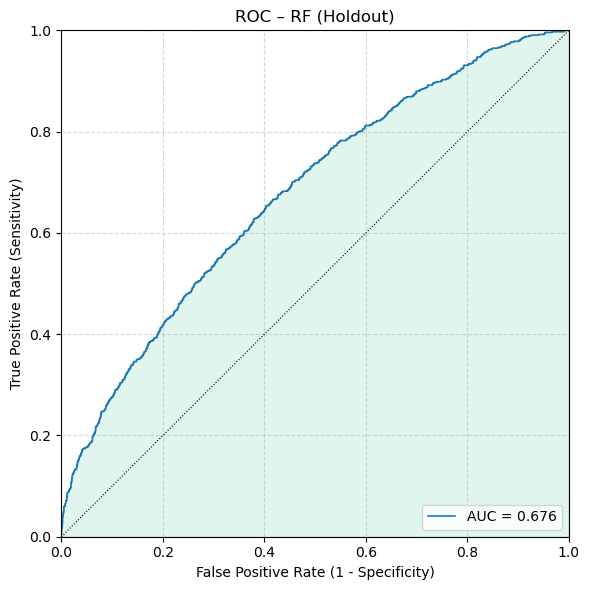

In [37]:
# ROC curve on holdout with best model
fig = create_roc_plot(
    y_holdout_eval, holdout_pred_proba,
    title=f"ROC – {best_model_name} (Holdout)"
)
fig.savefig(os.path.join(output_dir, "roc_best_model_holdout.png"),
            dpi=150, bbox_inches="tight")
plt.show()

## Model performance
#### CV vs holdout comparison / overfitting
- Cross-validation results were consistent across folds, with RF achieving the best overall CV performance (lowest RMSE ≈ 0.376 and highest AUC ≈ 0.686).
- The holdout confusion matrix shows similar behavior to CV expectations: RF generalizes reasonably well and does not display strong signs of overfitting.

#### Best-performing model type
- Random Forest performed best across all evaluation criteria
- LASSO slightly improved over the richer logit model (M3), but differences were small.
- RF likely dominates because it captures nonlinear relationships and interaction effects that linear logit models cannot.

#### Classification quality

- The model is strong at identifying non–fast-growth firms, but it misses many actual fast-growth firms, limiting usefulness for catching all high-growth cases.
- Sensitivity–specificity trade-off at the optimal threshold (0.36)
- **Sensitivity** = 144 / (144 + 596) ≈ 19%
- The model detects only about 1 in 5 fast-growing firms.
- **Specificity** (true negative rate) = 2881 / (2881 + 187) ≈ 94%
- The model is very good at avoiding false alarms.
- This reflects a conservative classifier: high specificity but low sensitivity.

### Precision as a screening tool
Precision ≈ 44%

Roughly half of the firms flagged as fast growth truly are, which may be acceptable for a targeted screening tool, but not for high-stakes decision-making alone.

### Business usefulness

The model could be deployed as an initial screening step, especially if the goal is to narrow down a shortlist of candidate high-growth firms.


### Key limitations

The event rate for fast growth is low, making prediction difficult and contributing to many false negatives.
Important drivers of growth may be missing (e.g., innovation measures, market conditions, management quality).
The model prioritizes avoiding false positives, which reduces its ability to catch true fast-growth firms.


**Next step →** Task 2: repeat the classification exercise separately for manufacturing and
services sub-samples using the same loss function.